In [2]:
import os
import matplotlib.pyplot as plt
from math import log2
import treelib as tl
from uuid import uuid4
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate
import numpy as np
import random
import pandas as pd
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

In [3]:
# reads the data stored in /data/file_name
# and returns the data as a list of lists in format 
# [[xi_0,xi_1,yi],
# [xj_0,xj_1,y_j],...]

def Read_File(file_name):
        
    data_file = open(os.getcwd()+"/data/"+file_name, "r")

    data = []
    for line in data_file:
        data.append([float(line.split()[0]),
                     float(line.split()[1]),
                     bool(int(line.split()[2]))])
    data_file.close()
    
    return data

In [4]:
# find the candidate splits for both features 
# and returns them as a list of lists in format 
# [[x_0 splits],
# [x1_splits]]

def Get_Cand_Splits(data):    
    cand_splits = []
    for feature_index in [0,1]:
        splits_sublist = []
        data.sort(key=lambda x: x[feature_index])
    
        for i in range(1,len(data)):
            if not data[i][feature_index] in splits_sublist and data[i][feature_index] != data[0][feature_index]:
                splits_sublist.append(data[i][feature_index])
        
        cand_splits.append(splits_sublist)  

    return cand_splits

In [5]:
# returns the unconditional entropy of the dataset H(Y)
def Get_Entropy(data):
    if len(data) == 0:
        return 0

    num_true = 0
    for point in data:
        if point[2]:
            num_true += 1         
    num_false = len(data) - num_true        

    P_true = num_true/len(data)
    P_false = num_false/len(data)

    H_y = 0
    if P_true > 0:
        H_y -= P_true*log2(P_true) 
    if P_false > 0:
        H_y -= P_false*log2(P_false)
    
    return H_y

In [6]:
#returns the entropy of a given split along a feature H(S)
def Get_Split_Entropy(data, split, feature_index):    
    
    num_above_split = 0
    for point in data:
        if point[feature_index] >= split:
            num_above_split += 1
            
    P_up = num_above_split/len(data)
    P_down = 1 - P_up
    
    H_s = 0
    if P_up > 0:
        H_s -= P_up*log2(P_up)
    if P_down > 0:
        H_s -= P_down*log2(P_down)
        
    return H_s

In [7]:
#returns the conditional entropy H(Y|S)
def Get_Conditional_Entropy(data, split, feature_index):

    data_above_split = []
    data_below_split = []
    for point in data:
        if point[feature_index] >= split:
            data_above_split.append(point)
        else:
            data_below_split.append(point)
    
    P_above_split = len(data_above_split)/len(data)
    P_below_split = 1 - P_above_split
    
    return P_above_split*Get_Entropy(data_above_split) + P_below_split*Get_Entropy(data_below_split)

In [8]:
# returns in the format [feature_index, split, gain_ratio]
def Get_Gain_Ratio(data, split, feature_index):
    numerator = Get_Entropy(data) - Get_Conditional_Entropy(data, split, feature_index)
    denominator = Get_Split_Entropy(data, split, feature_index)
    
    if denominator == 0:
        return [feature_index, split, 0]
    
    return [feature_index, split, numerator/denominator]

In [9]:
# returns the highest gain ratio split for the data in format [feature_index, split, gain_ratio]
def Get_Best_Split(data):
    gain_ratios = []
    for feature_index in [0,1]:
        for split in Get_Cand_Splits(data)[feature_index]:
            gain_ratios.append(Get_Gain_Ratio(data, split, feature_index))
            
    max_gain_ratio = [0,0,0]
    for ratio in gain_ratios:  
        if ratio[2] > max_gain_ratio[2]:
            max_gain_ratio = ratio
            
    return max_gain_ratio

In [10]:
def Get_Max_Conditional_Entropy(data):
    max_entropy = 0
    for feature_index in [0,1]:
        for split in Get_Cand_Splits(data)[feature_index]:
            entropy = Get_Conditional_Entropy(data, split, feature_index)
            if Get_Conditional_Entropy(data, split, feature_index) > max_entropy:
                max_entropy = entropy
                
    return max_entropy

In [11]:
# Checks if node should be a leaf
def Stopping_Criteria_Met(data):
    
    # Empty Node
    if len(data) == 0:
        return True
    
    # Zero Gain Ratio
    if Get_Best_Split(data)[2] == 0:
        return True
    
    # Zero Split Ratio
    if Get_Max_Conditional_Entropy(data) == 0:
        return True
    
    return False

In [12]:
# returns a left and right tree when splitting along a given value 
def Split_Data(data, split, feature_index):
    data_above_split = []
    data_below_split = []
    for point in data:
        if point[feature_index] >= split:
            data_above_split.append(point)
        else:
            data_below_split.append(point)
                
    return data_above_split, data_below_split

In [13]:
# returns the estimated y output of the data in the leaf, majority rules, predicts y = 1 on tie
def Get_Leaf_Value(data):
    true_count = 0
    for point in data:
        if point[2]:
            true_count += 1
    
    return true_count/len(data) >= 0.5

In [14]:
class Node():
    def __init__(self, data=None, best_split=None, left=None, right=None, leaf_value=None, key=None, parent_key=None):
        self.data = data
        self.best_split = best_split
        self.left = left
        self.right = right
        self.leaf_value = leaf_value
        self.key = key
        self.parent_key = parent_key
        
    def __str__(self):
        if self.best_split is not None:
            to_return = "x"+str(self.best_split[0]) + " >= " + str(self.best_split[1])
        else:
            to_return = str(self.leaf_value)
        
        return to_return
    
    def Build_Tree(self):
        self.key = str(uuid4())
        
        if not Stopping_Criteria_Met(self.data):
            best_split = Get_Best_Split(self.data)
            self.best_split = best_split        

            left_subtree_data, right_subtree_data = Split_Data(self.data, best_split[1], best_split[0])
            self.left = Node(data=left_subtree_data, parent_key=self.key).Build_Tree()
            self.right = Node(data=right_subtree_data, parent_key=self.key).Build_Tree()

        else:
            self.leaf_value = Get_Leaf_Value(self.data)
        
        return self
        

In [15]:
def Print_Tree(node, stack):
    if node is None:
        return
    if node.parent_key is not None:
        stack.append([str(node),node.key,node.parent_key])
    else:
        stack.append([str(node),node.key])
        
    Print_Tree(node.left, stack)
    Print_Tree(node.right, stack)

In [16]:
##### Quesiotn 2.3 ######

data = Read_File("Druns.txt")

cand_splits = Get_Cand_Splits(data)
table = [["feature_index: ","c: ","GainRatio: "]]
for feature_index in [0,1]:
    for i in range(len(cand_splits[feature_index])):
        table.append([str(feature_index), str(cand_splits[feature_index][i]), str(Get_Gain_Ratio(data, cand_splits[feature_index][i], feature_index)[2])])

print(tabulate(table))

--------------  ----  ---------------------
feature_index:  c:    GainRatio:
0               0.1   0.10051807676021828
1               -1.0  0.10051807676021828
1               0.0   0.055953759631263686
1               1.0   0.00578004220515232
1               2.0   0.0011443495172767494
1               3.0   0.016411136842102023
1               4.0   0.049749064181778546
1               5.0   0.11124029586339801
1               6.0   0.23609960614360798
1               7.0   0.05595375963126384
1               8.0   0.4301569161309807
--------------  ----  ---------------------


In [17]:
##### Question 2.4 #####
# SEE PDF FOR IMAGE

data = Read_File("D3Leaves.txt")

tree = Node(data)
tree.Build_Tree()

print(tree)
print(tree.left)
print(tree.right)
print(tree.right.left)
print(tree.right.right)

x0 >= 10.0
True
True
None
None


In [18]:
##### Question 2.5 #####
# D1.txt, see pdf for image

data = Read_File("D1.txt")

tree = Node(data)
tree.Build_Tree()

print(tree)
print(tree.left)
print(tree.right)

x1 >= 0.201829
True
False


In [19]:
#D2.txt

# adds to a stack of information about the nodes in the tree in the format 
# [[Node_Rule, key, parent_key]]
def Make_Node_List(node, stack):
    if node is None:
        return
    if node.parent_key is not None:
        stack.append([str(node),node.key,node.parent_key])
    else:
        stack.append([str(node),node.key])
        
    Make_Node_List(node.left, stack)
    Make_Node_List(node.right, stack)



data = Read_File("D2.txt")

tree = Node(data)
tree.Build_Tree()

stack = []
Make_Node_List(tree, stack)

# Prints in format friendly for LaTex table
for item in stack:
    if len(item) == 2:
        print("$"+item[0] + "$ & " + item[1]+ " \\\\")
    else:
        print("$"+item[0] + "$ & " + item[1] + " & " + item[2]+" \\\\")

$x0 >= 0.533076$ & 2dfcaff3-4ba0-42d9-9f43-d75b0404c7b2 \\
$x1 >= 0.228007$ & 8a15b88a-9126-498a-ba2c-f25b05764dcd & 2dfcaff3-4ba0-42d9-9f43-d75b0404c7b2 \\
$x1 >= 0.424906$ & bc34edbf-e216-4ead-a433-1899765bd040 & 8a15b88a-9126-498a-ba2c-f25b05764dcd \\
$True$ & 9796595b-353e-426a-afd3-88278c27fd01 & bc34edbf-e216-4ead-a433-1899765bd040 \\
$x0 >= 0.708127$ & af8b1c16-b8a8-444c-961f-e938b9cce71d & bc34edbf-e216-4ead-a433-1899765bd040 \\
$True$ & d39f773b-78eb-4f6b-94c2-eae749a05f7b & af8b1c16-b8a8-444c-961f-e938b9cce71d \\
$x1 >= 0.32625$ & a303dff3-ec66-4acc-941b-f6c119af63d0 & af8b1c16-b8a8-444c-961f-e938b9cce71d \\
$x0 >= 0.595471$ & f752effe-1bff-40e8-9281-a78d201551a6 & a303dff3-ec66-4acc-941b-f6c119af63d0 \\
$x0 >= 0.646007$ & 70d65386-314a-47fe-9174-0931f49f08f7 & f752effe-1bff-40e8-9281-a78d201551a6 \\
$True$ & c2623969-6708-4a2a-ba9e-07f07df6551c & 70d65386-314a-47fe-9174-0931f49f08f7 \\
$x1 >= 0.403494$ & ee97fdb3-c4fc-4eb2-93c2-bb14601ceedd & 70d65386-314a-47fe-9174-0931f49f

In [20]:
#prints the same information about the D2.txt tree in a table
table = [["Node:","Key:","Parent Key:"]]
for i in range(len(stack)):
    if not i == 0:
        table.append([stack[i][0], stack[i][1], stack[i][2]])
    else:
        table.append([stack[i][0], stack[i][1], "N/A"])
    
print(tabulate(table))

--------------  ------------------------------------  ------------------------------------
Node:           Key:                                  Parent Key:
x0 >= 0.533076  2dfcaff3-4ba0-42d9-9f43-d75b0404c7b2  N/A
x1 >= 0.228007  8a15b88a-9126-498a-ba2c-f25b05764dcd  2dfcaff3-4ba0-42d9-9f43-d75b0404c7b2
x1 >= 0.424906  bc34edbf-e216-4ead-a433-1899765bd040  8a15b88a-9126-498a-ba2c-f25b05764dcd
True            9796595b-353e-426a-afd3-88278c27fd01  bc34edbf-e216-4ead-a433-1899765bd040
x0 >= 0.708127  af8b1c16-b8a8-444c-961f-e938b9cce71d  bc34edbf-e216-4ead-a433-1899765bd040
True            d39f773b-78eb-4f6b-94c2-eae749a05f7b  af8b1c16-b8a8-444c-961f-e938b9cce71d
x1 >= 0.32625   a303dff3-ec66-4acc-941b-f6c119af63d0  af8b1c16-b8a8-444c-961f-e938b9cce71d
x0 >= 0.595471  f752effe-1bff-40e8-9281-a78d201551a6  a303dff3-ec66-4acc-941b-f6c119af63d0
x0 >= 0.646007  70d65386-314a-47fe-9174-0931f49f08f7  f752effe-1bff-40e8-9281-a78d201551a6
True            c2623969-6708-4a2a-ba9e-07f07df6551c  70d

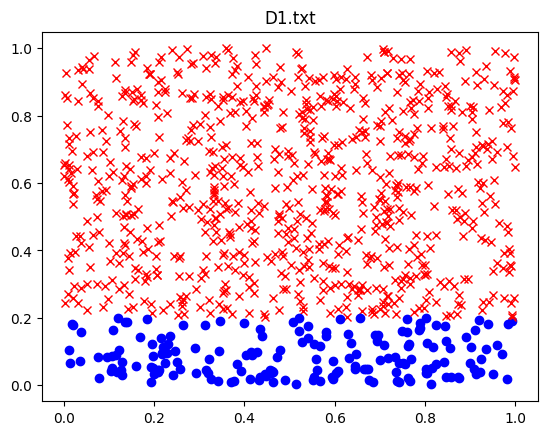

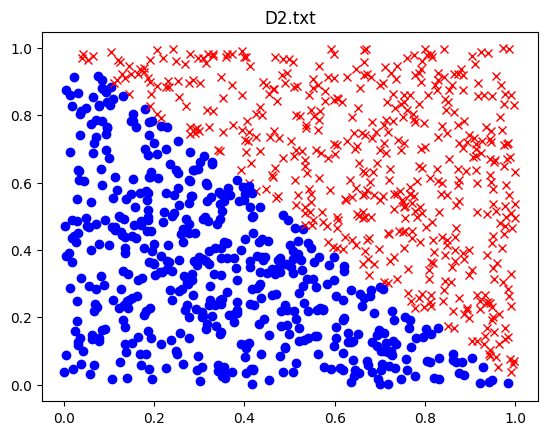

In [21]:
##### Question 2.6 #####
def Make_Scatterplot(data, title=""):
    for point in data:
        if point[2]:
            plt.plot(point[0], point[1],"x",color="red")
        else:
            plt.plot(point[0], point[1],"o",color="blue")
    
    plt.title(title)
    plt.show()

file_name = "D1.txt"
data = Read_File(file_name)
Make_Scatterplot(data, file_name)

file_name = "D2.txt"
data = Read_File(file_name)
Make_Scatterplot(data, file_name)

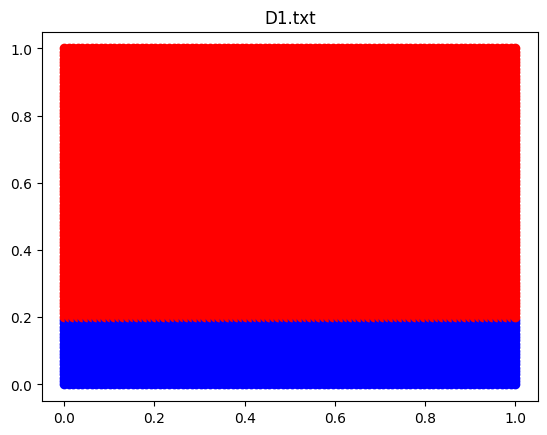

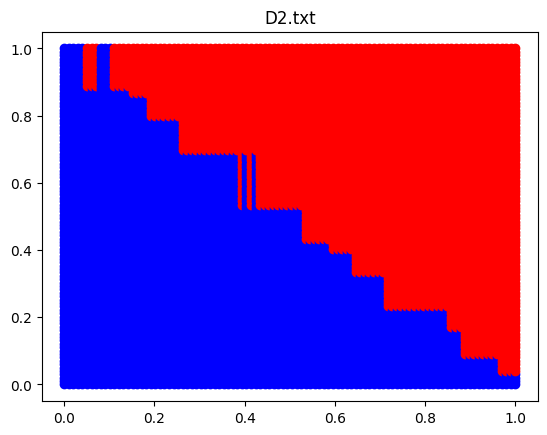

In [22]:
def Plot_Point(node, point):
    if node.best_split is None:
        if node.leaf_value:
            plt.plot(point[0], point[1],"o",color="red")
        else:
            plt.plot(point[0], point[1],"o",color="blue")
    else:
        if point[node.best_split[0]] >= node.best_split[1]:
            Plot_Point(node.left, point)
        else:
            Plot_Point(node.right, point)
                
def Make_Regions(tree, x0_min=0, x0_max=1, x1_min=0, x1_max=1, n=100):
    points = []
    for x0 in np.linspace(x0_min, x0_max, n):
        for x1 in np.linspace(x1_min, x1_max, n):
            points.append([x0, x1, True])
    
    for point in points:
        Plot_Point(tree, point)
        
        
        

file_name = "D1.txt"       
data = Read_File(file_name)
tree = Node(data)
tree.Build_Tree()
Make_Regions(tree)
plt.title(file_name)
plt.show()

file_name = "D2.txt"       
data = Read_File(file_name)
tree = Node(data)
tree.Build_Tree()
Make_Regions(tree)
plt.title(file_name)
plt.show()

In [66]:
##### Question 2.7 #####
# 0. Error
# 1. number of nodes in tree, n
# 2. plot 
# 3. Region Graph
data = Read_File("DBig.txt")
random.shuffle(data)

training_data = data[:8192]
test_data = data[8192:]

nums = [32,128,512,2048]

training_datasets = []
for num in nums:
    training_datasets.append(training_data[:num])

In [67]:
def Test_Point(node, point):

    if node.best_split is not None:
        if point[node.best_split[0]] >= node.best_split[1]:
            Test_Point(node.left, point)
        else:
            Test_Point(node.right, point)
    
    if node.leaf_value is not None:
        global prediction 
        prediction = node.leaf_value
            

                
def Test_Accuracy(tree, test_data):
    num_correct = 0
    for point in test_data:
        
        Test_Point(tree, point)
        if prediction == point[2]:
            num_correct += 1
    
    return 1 - num_correct/len(test_data)


def Count_Nodes(node):
    if node is None:
        return 0
        
    return 1 + Count_Nodes(node.left) + Count_Nodes(node.right)

In [68]:
trees = []
for dataset in training_datasets:
    tree = Node(dataset)
    tree.Build_Tree()
    trees.append(tree)

error_rates = []
for tree in trees:
    error_rates.append(Test_Accuracy(tree, test_data))

node_counts = []
for tree in trees:
    node_counts.append(Count_Nodes(tree))

In [69]:
table = [["N: ","Node Counts: ", "Error Rate: "]]
for i in range(len(nums)):
    table.append([nums[i], Count_Nodes(trees[i]), error_rates[i]])

print(tabulate(table))

----  ------------  --------------------
N:    Node Counts:  Error Rate:
32    9             0.1836283185840708
128   13            0.0879424778761062
512   53            0.07134955752212391
2048  129           0.027654867256637128
----  ------------  --------------------


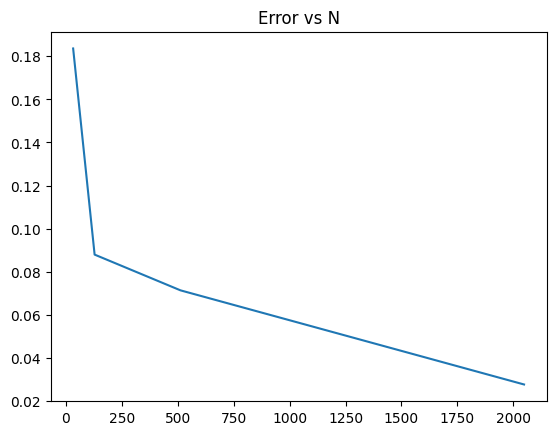

In [70]:
plt.plot(nums, error_rates)
plt.title("Error vs N")
plt.show()

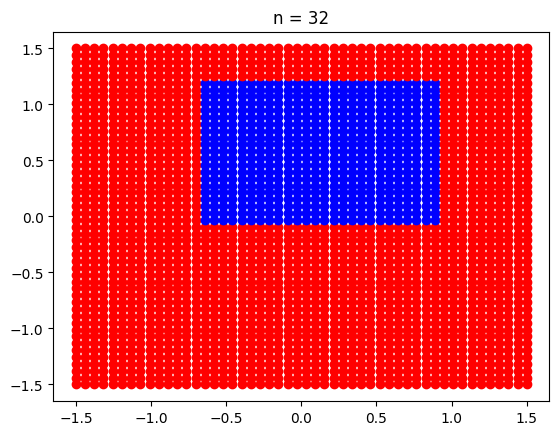

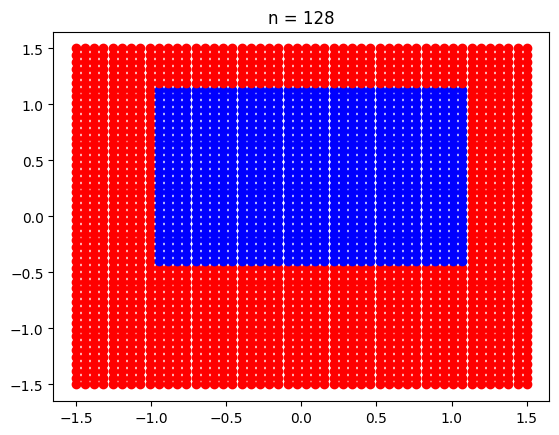

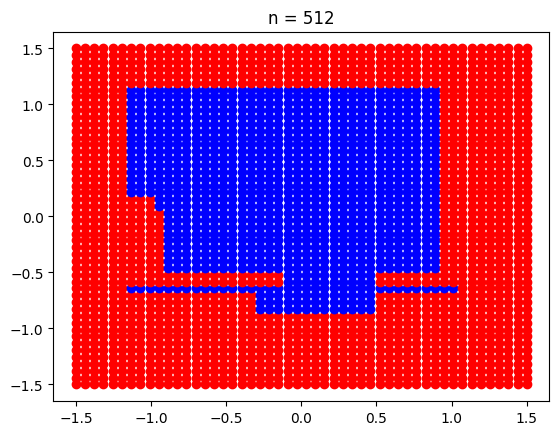

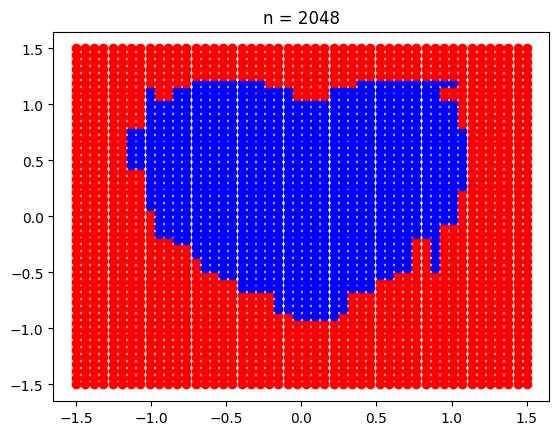

In [71]:
for i in range(len(trees)):
    Make_Regions(trees[i],-1.5,1.5,-1.5,1.5, 50)
    plt.title("n = " + str(nums[i]))
    plt.show()


In [72]:
##### Question 3 #####

# loads data into datafram
def Read_File_to_DF(file_name):
        
    data_file = open(os.getcwd()+"/data/"+file_name, "r")
    df = pd.read_csv(data_file, sep=' ', header=None, names=['x0', 'x1', 'y'])
    data_file.close()
    
    return df

In [73]:
df = Read_File_to_DF("DBig.txt")
#randomizes the order of the data
df = df.sample(frac=1).reset_index(drop=True)

nums = [32, 128, 512, 2048, 8192]
training_models = []
for num in nums:
    training_df = df[:num]
    inputs = training_df.drop("y", axis="columns")
    output = training_df.drop(["x0","x1"], axis="columns")
    
    model = DecisionTreeClassifier()
    model.fit(inputs, output)

    training_models.append(model)

df_test = df[8192:]
test_inputs = df_test.drop("y", axis="columns")
test_output = df_test.drop(["x0","x1"], axis="columns")

model = DecisionTreeClassifier()
model.fit(inputs, output)

table = [["n: ","node count: ","error: "]]
for i in range(len(training_models)):
    table.append([nums[i], training_models[i].tree_.node_count, 1-training_models[i].score(test_inputs, test_output)])
    
print(tabulate(table))

----  -----------  --------------------
n:    node count:  error:
32    17           0.16095132743362828
128   29           0.09900442477876104
512   45           0.03042035398230092
2048  131          0.030973451327433676
8192  255          0.012721238938053103
----  -----------  --------------------


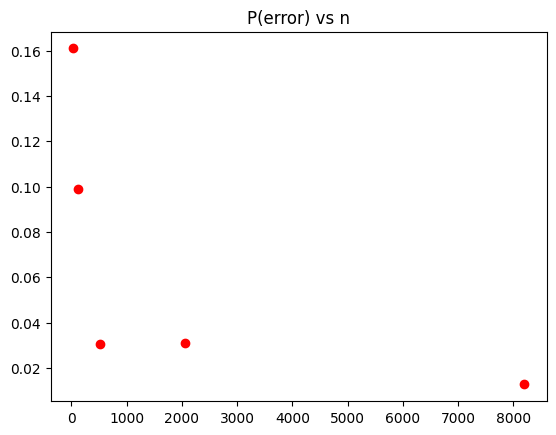

In [74]:
for i in range(1,len(table)):
    plt.plot(table[i][0],table[i][2],"o",color="red")
    plt.title("P(error) vs n")

In [75]:
##### Question 4 #####
# No Noise

a,b,n = 0, 2*np.pi, 16

# create training data
x_training = sorted(np.random.uniform(a, b, n))
y_training = np.sin(x_training)
poly = lagrange(x_training, y_training)
y_prediction = poly(x_training)


# create test data
x_test = np.array(sorted(np.random.uniform(a, b, n)))
y_test = np.sin(x_test)
y_test_prediction = poly(x_test)

training_error = np.square(np.subtract(y_training,y_prediction)).mean()
test_error = np.square(np.subtract(y_test,y_test_prediction)).mean()

print("training error: "+str(training_error)+"\n")
print("test error: "+str(test_error)+"\n")
print("training error to test error ratio: "+str(training_error/test_error))


training error: 0.00048571206336048294

test error: 0.0005642899020017905

training error to test error ratio: 0.8607491674712652


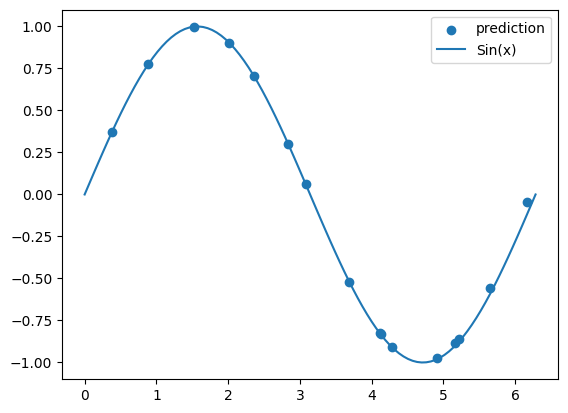

In [76]:
plt.scatter(x_training, y_prediction,
            label='prediction')
plt.plot(np.linspace(a,b,100),np.sin(np.linspace(a,b,100)), label="Sin(x)")

plt.legend()
plt.show()

In [77]:
# With Noise
sigma = 1

# create training data
x_training = sorted(np.random.uniform(a, b, n))
for x in x_training:
    x += np.random.normal(0,sigma)
y_training = np.sin(x_training)
poly = lagrange(x_training, y_training)
y_prediction = poly(x_training)


# create test data
x_test = np.array(sorted(np.random.uniform(a, b, n)))
y_test = np.sin(x_test)
y_test_prediction = poly(x_test)

training_error = np.square(np.subtract(y_training,y_prediction)).mean()
test_error = np.square(np.subtract(y_test,y_test_prediction)).mean()

print("training error: "+str(training_error)+"\n")
print("test error: "+str(test_error)+"\n")
print("training error to test error ratio: "+str(training_error/test_error))

training error: 4.979311883066267e-06

test error: 2.7050932425647054e-06

training error to test error ratio: 1.840717282760046


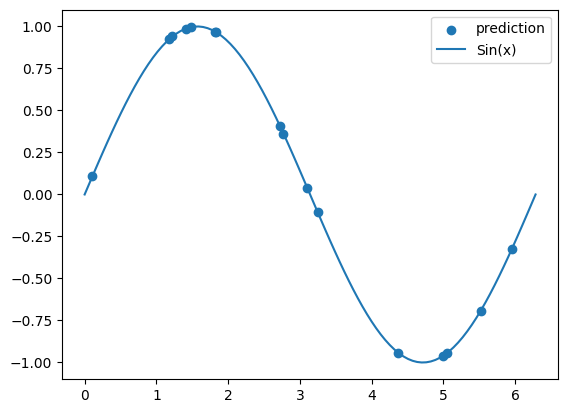

In [78]:
plt.scatter(x_training, y_prediction,
            label='prediction')
plt.plot(np.linspace(a,b,100),np.sin(np.linspace(a,b,100)), label="Sin(x)")

plt.legend()
plt.show()